In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import rasterio as rio

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from skimage.segmentation import mark_boundaries
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist

from PIL import Image
from tqdm import tqdm


In [ ]:
images_dir ='../data/images'
masks_dir = '../data/masks'
metrics_dir='../metrics'
models_dir='../models'


images = sorted(os.listdir(images_dir))
masks = sorted(os.listdir(masks_dir))
print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)


Number of images: 203
Number of masks: 203


In [ ]:
train_images=np.array(train_images)
train_masks=np.array(train_masks)
val_images=np.array(val_images)
val_masks=np.array(val_masks)

In [ ]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  '#FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = '#E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [ ]:
#Generate class label map
#Building: #3C1098
#Land (unpaved area): #8429F6
#Road: #6EC1E4
#Vegetation: #FEDD3A
#Water: #E2A929
#Unlabeled: #9B9B9B
#Object
color_map = {
    (60, 16, 152):0,   # Building #Dark voilet
    (132, 41, 246):1,  # Land (unpaved area) # Bright voilet
    (110, 193, 228):2, # Road # soft blue
    (254, 221, 58):3,  # Vegetation # Bright yellow
    (226, 169, 41):4,  # Water # Bright orange
    (155, 155, 155):5  # Object # Dark Gray
}



In [ ]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    # print(f"DEBUG: Inside rgb_to_2D_label. Input label type: {type(label)}, shape: {label.shape}, dtype: {label.dtype}")

    # Ensure label is a numpy array and has 3 channels (HxWx3)
    if not isinstance(label, np.ndarray) or label.ndim != 3 or label.shape[2] != 3:
        # Removed: print(f"WARNING: Input label to rgb_to_2D_label does not have expected HxWx3 shape. Got {label.shape}")
        raise ValueError(f"Input to rgb_to_2D_label must be an HxWx3 numpy array, but got shape {label.shape}")

    height, width, _ = label.shape
    label_seg = np.zeros((height, width), dtype=np.uint8) # Initialize as a 2D array (HxW)

    # print(f"DEBUG: Type of Building: {type(Building)}, Land: {type(Land)}, Road: {type(Road)}, Vegetation: {type(Vegetation)}, Water: {type(Water)}, Unlabeled: {type(Unlabeled)}")
    # print(f"DEBUG: Building value: {Building}, type: {type(Building)}, dtype: {Building.dtype}")
    # print(f"DEBUG: Land value: {Land}, type: {type(Land)}, dtype: {Land.dtype}")
    # print(f"DEBUG: Road value: {Road}, type: {type(Road)}, dtype: {Road.dtype}")
    # print(f"DEBUG: Vegetation value: {Vegetation}, type: {type(Vegetation)}, dtype: {Vegetation.dtype}")
    # print(f"DEBUG: Water value: {Water}, type: {type(Water)}, dtype: {Water.dtype}")
    # print(f"DEBUG: Unlabeled value: {Unlabeled}, type: {type(Unlabeled)}, dtype: {Unlabeled.dtype}")

    try:
        label_seg[np.all(label == Building, axis=-1)] = 0
    except Exception as e:
        print(f"ERROR: Failed at Building comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Land, axis=-1)] = 1
    except Exception as e:
        print(f"ERROR: Failed at Land comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Road, axis=-1)] = 2
    except Exception as e:
        print(f"ERROR: Failed at Road comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Vegetation, axis=-1)] = 3
    except Exception as e:
        print(f"ERROR: Failed at Vegetation comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Water, axis=-1)] = 4
    except Exception as e:
        print(f"ERROR: Failed at Water comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Unlabeled, axis=-1)] = 5
    except Exception as e:
        print(f"ERROR: Failed at Unlabeled comparison: {e}")
        raise

    return label_seg

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

kmeans=KMeans(n_clusters=6, random_state=42,n_init='auto')
mse=[]
accuracy=[]
precision=[]
recall=[]
f1=[]
for i in range(len(train_images)):
  image_path=os.path.join(images_dir, train_images[i])
  image=plt.imread(image_path)
  image=image.reshape(-1,3)
  mask_pred = kmeans.fit_predict(image)
  mask_pred_flat=mask_pred.flatten()
  mask_data = os.path.join(masks_dir, train_masks[i])
  mask_data=plt.imread(mask_data)
  mask_labels= rgb_to_2D_label(mask_data)
  mask_labels_flat=mask_labels.flatten()
  mse.append(np.mean((mask_pred_flat - mask_labels_flat)**2))
  accuracy.append(accuracy_score(mask_labels_flat, mask_pred_flat))
  precision.append(precision_score(mask_labels_flat, mask_pred_flat, average='weighted'))
  recall.append(recall_score(mask_labels_flat, mask_pred_flat, average='weighted'))
  f1.append(f1_score(mask_labels_flat, mask_pred_flat, average='weighted'))



In [ ]:
val_mse=[]
val_accuracy=[]
val_precision=[]
val_recall=[]
val_f1=[]


for i in range(len(val_images)):
  image_path=os.path.join(images_dir, val_images[i])
  image=plt.imread(image_path)
  image=image.reshape(-1,3)
  mask_pred = kmeans.predict(image)
  mask_pred_flat=mask_pred.flatten()
  mask_data = os.path.join(masks_dir, val_masks[i])
  mask_data=plt.imread(mask_data)
  mask_labels= rgb_to_2D_label(mask_data)
  mask_labels_flat=mask_labels.flatten()
  val_mse.append(np.mean((mask_pred_flat - mask_labels_flat)**2))
  val_accuracy.append(accuracy_score(mask_labels_flat, mask_pred_flat))
  val_precision.append(precision_score(mask_labels_flat, mask_pred_flat, average='weighted'))
  val_recall.append(recall_score(mask_labels_flat, mask_pred_flat, average='weighted'))
  val_f1.append(f1_score(mask_labels_flat, mask_pred_flat, average='weighted'))


In [ ]:
#save model
import pickle
with open(os.path.join(models_dir, 'kmeans_model.pkl'), 'wb') as file:
    pickle.dump(kmeans, file)

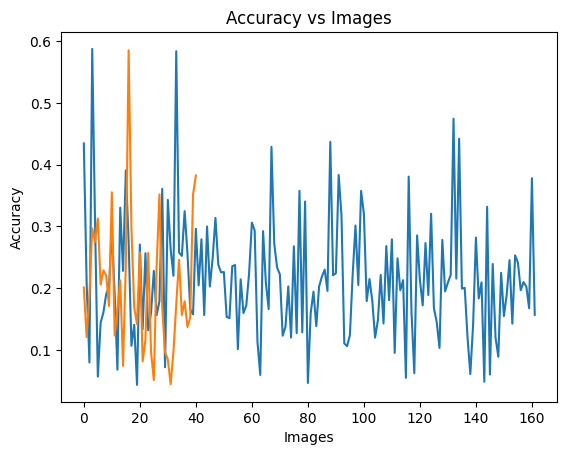

In [ ]:
#mse, accuracy, precision, f1
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Accuracy vs Images')
plt.xlabel('Images')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(metrics_dir, 'kmeans_accuracy.png'))
plt.show()




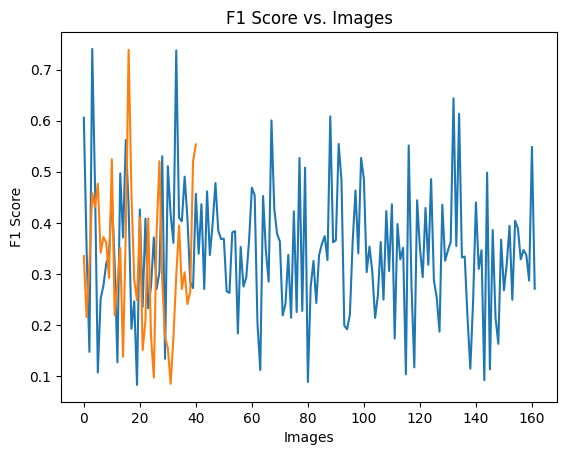

In [ ]:
plt.plot(f1)
plt.plot(val_f1)
plt.title('F1 Score vs. Images')
plt.xlabel('Images')
plt.ylabel('F1 Score')
plt.savefig(os.path.join(metrics_dir, 'kmeans_f1.png'))
plt.show()

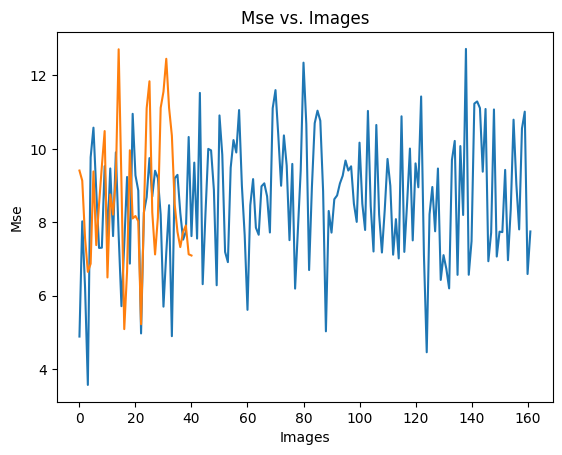

In [ ]:
plt.plot(mse)
plt.plot(val_mse)
plt.title('Mse vs. Images')
plt.xlabel('Images')
plt.ylabel('Mse')
plt.savefig(os.path.join(metrics_dir, 'kmeans_mse.png'))
plt.show()


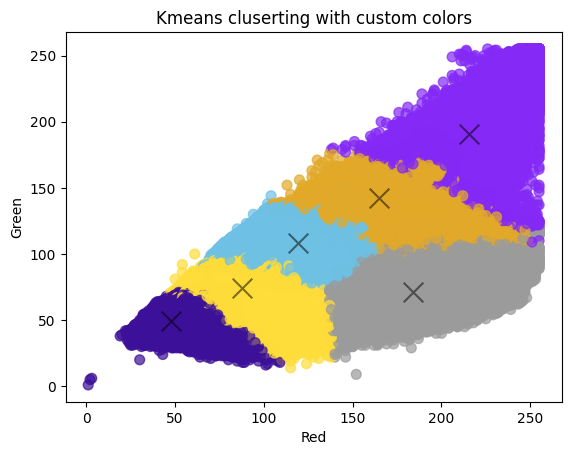

In [ ]:
#6EC1E4
#Vegetation: #FEDD3A
#Water: #E2A929
#Unlabeled: #9B9B9B
custom_colors=['#3C1098', '#8429F6', '#6EC1E4', '#FEDD3A', '#E2A929', '#9B9B9B']

image_data=plt.imread(os.path.join(images_dir, train_images[0]))
image=image_data.reshape(-1,3)
kmeans.fit(image)
mask_pred=kmeans.predict(image)
labels=kmeans.labels_
centroids=kmeans.cluster_centers_

plt.scatter(image[:,0], image[:,1], c=[custom_colors[label]for label in labels], alpha=0.7, s=50)
plt.scatter(centroids[:,0], centroids[:,1], c='black', marker='x', s=200, alpha=0.5)
plt.title('Kmeans cluserting with custom colors')
plt.xlabel('Red')
plt.ylabel('Green')
plt.show()







In [ ]:
import numpy as np

def apply_color_map(mask, color_map):
    # Ensure mask is a numpy array (it should be (H, W) with integer class labels)
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask)

    # The mask is now (H, W), so unpack only height and width
    height, width = mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # The input color_map maps RGB_tuple -> integer_label.
    # We need to reverse this to map integer_label -> RGB_tuple for easier lookup.
    label_to_rgb = {v: k for k, v in color_map.items()}


    # Create a lookup table (palette) for colors.
    # Assuming labels are 0-indexed and contiguous up to max_label.
    # If labels are sparse, max_label + 1 needs to be adjusted or handle missing labels.
    max_label = max(label_to_rgb.keys())
    palette = np.zeros((max_label + 1, 3), dtype=np.uint8)
    for label_int, rgb_tuple in label_to_rgb.items():
        palette[label_int] = list(rgb_tuple) # Assign RGB values to palette rows

    # Use the mask values as indices into the palette to get the colored image
    # mask is (H,W), palette is (num_classes, 3)
    # The result `colored_mask` will be (H,W,3)
    colored_mask = palette[mask]

    return colored_mask

Actual color mask output

    
    # Building #Dark voilet
    # Land (unpaved area) # Bright voilet
    # Road # soft blue
    # Vegetation # Bright yellow
    # Water # Bright orange
    # Object # Dark Gray

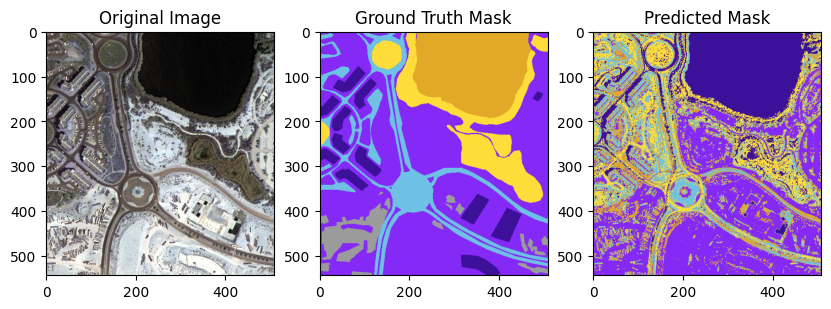

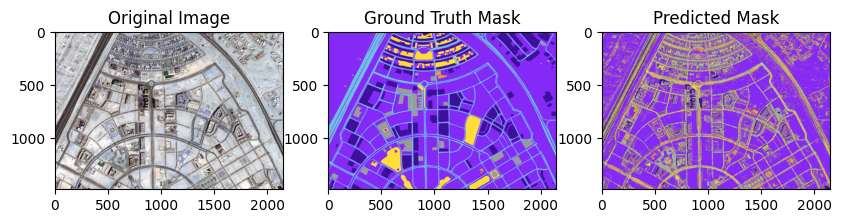

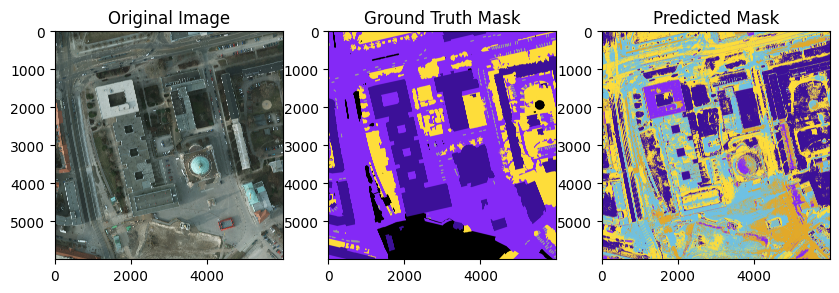

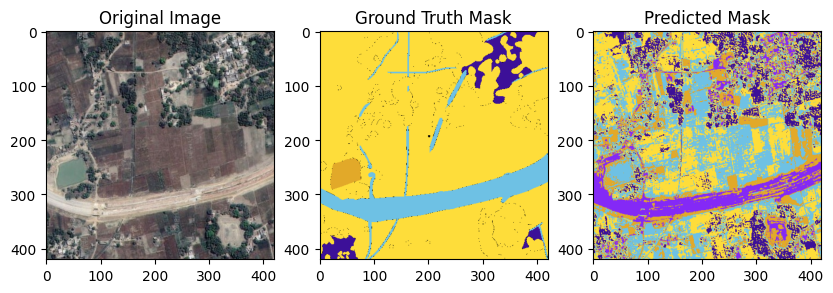

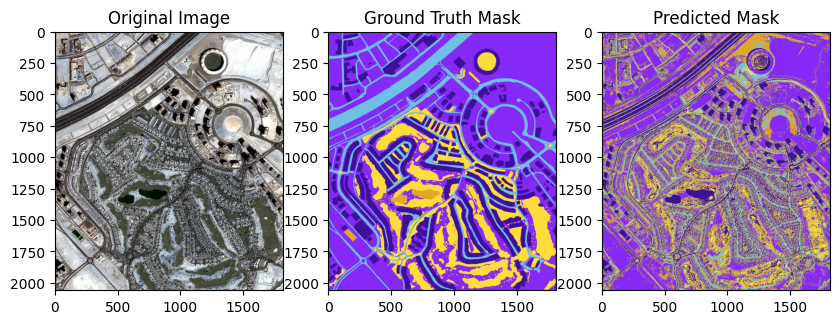

In [ ]:
# get mask lable from mask_data
for i in np.arange(0, 5):
    idx=np.random.randint(0, len(val_images))
    image_data=plt.imread(os.path.join(images_dir, val_images[idx]))
    mask_data=plt.imread(os.path.join(masks_dir, val_masks[idx]))
    mask_pred=kmeans.predict(image_data.reshape(-1,3))
    mask_pred=mask_pred.reshape(image_data.shape[0], image_data.shape[1])
    mask_pred_color=apply_color_map(mask_pred, color_map)
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(image_data)
    axes[0].set_title('Original Image')
    axes[1].imshow(mask_data)
    axes[1].set_title('Ground Truth Mask')
    axes[2].imshow(mask_pred_color)
    axes[2].set_title('Predicted Mask')


In [ ]:
#save masks in the kmeans_mask
for i in range(len(images)):
  image_path=os.path.join(images_dir, images[i])
  image_data=plt.imread(image_path)
  mask_pred = kmeans.predict(image_data.reshape(-1, 3))
  mask_pred=mask_pred.reshape(image_data.shape[0], image_data.shape[1])
  mask_pred_color=apply_color_map(mask_pred, color_map)
  #save mask_pred_color as .png
  plt.imsave(os.path.join(kmeans_masks_dir, masks[i]), mask_pred_color)



In [ ]:
val_f1_score=np.max(val_f1)
print(f"Best F1 Score: {val_f1_score:.2f}")

Best F1 Score: 0.74


In [ ]:
train_f1_score=np.max(f1)
print(f"Best F1 Score: {train_f1_score:.2f}")

Best F1 Score: 0.74


In [ ]:
train_accuracy_score=np.max(accuracy)
print(f"Best Accuracy Score: {train_accuracy_score:.2f}")

Best Accuracy Score: 0.59


In [ ]:
val_accuracy_score=np.max(val_accuracy)
print(f"Best Accuracy Score: {val_accuracy_score:.2f}")

Best Accuracy Score: 0.59


In [ ]:
train_mse_score=np.max(mse)
print(f"Best MSE: {train_mse_score:.2f}")

Best MSE: 12.72


In [ ]:
val_mse_score=np.max(val_mse)
print(f"Best MSE: {val_mse_score:.2f}")

Best MSE: 12.71


In [ ]:
metrics_df={'f1':[train_f1_score, val_f1_score], 'accuracy':[train_accuracy_score, val_accuracy_score], 'mse':[train_mse_score, val_mse_score]}
metrics_df=pd.DataFrame(metrics_df, index=['training', 'validation'])
metrics_df

,f1,accuracy,mse
training,0.740254,0.587622,12.723673
validation,0.738480,0.585389,12.713935


In [ ]:
metrics_df.to_csv(os.path.join(metrics_dir, 'kmeans_metrics.csv'))